In this notebook, we implement a modification of the mean-reverting trading strategy proposed by Marco Avellaneda and Jeong-Hyun Lee in their 2008 paper "Statistical Arbitrage in the U.S. Equities Market". We employ a variable number of market factor portfolios, determined using the Marchenko-Pastur distribution. Additionally, we adjust our strategy using volatility targeting, as described in the paper "The Impact of Volatility Targeting" (2018) by Harvey et al.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import quantstats as qs
import yfinance as yf
from sklearn.linear_model import LinearRegression
from pytictoc import TicToc

First, we download data from Yahoo Finance for the S&P500 companies as well as the SPY index to be used as a benchmark and returns data.

In [2]:
# Get the SP500 tickers.
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Replace dots by dashes to avoid issues when using yfinace.
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-', regex = True)

# Get the list of tickers. 
symbols_list = sp500['Symbol'].unique().tolist()

# Set start and end dates for the data.
start_date = pd.to_datetime('2018-01-01')

end_date = pd.to_datetime('2021-01-01')

# Download stock data using yfinace.
asset_prices = yf.download(tickers = symbols_list, 
                           start = start_date,
                           end = end_date)['Adj Close']

# Download SPX data to be used as benchmark.
spx = yf.download('^GSPC', 
                  start = start_date, 
                  end = end_date)['Adj Close']

[*********************100%%**********************]  503 of 503 completed

6 Failed downloads:
['KVUE', 'CEG']: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
['SOLV', 'VLTO', 'GEV', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1514782800, endDate = 1609477200")
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Compute returns.
asset_prices.fillna(value = 0, inplace = True)
asset_returns = asset_prices.pct_change().drop(asset_prices.index[0])
nan_cols = asset_returns.columns[asset_returns.isna().any() == True]
asset_returns.drop(columns = nan_cols, axis = 1, inplace = True)

spx_returns = spx.pct_change().drop(spx.index[0])

## PCA eigenportfolios.

Following the notation set by the original paper of Avellaneda and Lee (2007), we denote by $R_i$ the return of $i^{\text{th}}$ stock. Without loss of generality we consider a universe of $n$ stocks. Let $F$ represent the return of the $\textit{market portfolio}$. For each stock in the universe we decompose the return into a systematic component due to the market return $F$ and an uncorrelated idiosyncratic component $\tilde{R}_i$. A simple regression model used for this decomposition yields
\begin{align}
    R_i
    =
    \beta_i \> F
    +
    \tilde{R}_i
    ,
\end{align}
where $\beta_i$ is a regression coefficient. We will consider a multi-factor model of the form
\begin{align}
    R_i
    =
    \sum_{j = 1}^{K} \> \beta_{ij} \> F_{j}
    +
    \tilde{R}_i
    ,
\end{align}
where $\{ F_j \}_{j = 1}^{K}$ are the $K$ market portfolio factors.

We take the market portfolio returns to be emanating from a PCA decomposition eigenportfolios. The weights for $j^{\text{th}}$ eigenportfolios are calculated by taking $j^{\text{th}}$ eigenvector $v_j = (v_j^{(1)},..., v_j^{(n)})$ and dividing it element-wise by $\bar{\sigma} =  (\bar{\sigma}_i^{(1)},..., \bar{\sigma}_i^{(n)})$, the sample standard deviations of the stock returns. So, the market portfolio returns are calculated as
\begin{align}
    F_j
    =
    \sum_{i = 1}^{n} \> \frac{v_j^{(i)}}{\bar{\sigma}_i} \> R_i
    ,
\end{align}
We choose the the eigenvectors corresponding to the eigenvalues lying outside of the range predicted by the Marchenko-Pastur distribution. Thus, we discard eigenvalues less than
\begin{align}
    \lambda_{\text{max}}
    =
    \left ( 1 + \sqrt{\frac{n}{m}} \right )^2
    ,
\end{align}
where $m$ is the number of rows in $R$, i.e. the number of observations, and $n$ is the number of columns, i.e. different stocks.

In [4]:
def MP_cleaning(D: np.array, m: int, n: int, verbose: bool = False):
    """
    Clean the eigenvalue spectrum D based on the Marchenko-Pastur distribution.

    Parameters:
    -----------
    D : np.array
        Array of eigenvalues from a covariance or correlation matrix.

    m : int
        Number of observations (rows in the matrix).

    n : int
        Number of variables (columns in the matrix).

    verbose : bool, optional
        Whether to print the number of significant components. Default is False.

    Returns:
    --------
    np.array
        Cleaned eigenvalue spectrum with noisy eigenvalues set to 0.

    Notes:
    ------
    This function applies the Marchenko-Pastur (MP) cleaning procedure to filter out noisy eigenvalues
    based on the given eigenvalue spectrum `D`, number of observations `m`, and number of variables `n`.
    It calculates the threshold (`max_eig`) based on the MP distribution and sets eigenvalues below this
    threshold to 0 in the cleaned spectrum.
    """
    max_eig = (1 + np.sqrt(n / m)) ** 2
    
    cleanD = np.array([eig if eig >= max_eig else 0 for eig in D])
    
    if verbose:
        print(f'Number of significant components is {np.sum(cleanD > 0)}.')
        
    return cleanD

def get_portfolio(weights: pd.DataFrame, stocks: list, norm = True):
    """
    Create a portfolio DataFrame given weigths and stocks.

    Parameters:
        weights (pd.DataFrame): weights.
        stocks (list): A list of stock names.
        
    Returns:
        pd.DataFrame: A DataFrame containing the portfolio weights.
    """
    if norm:
    # Check if weights are normalised.
        if np.sum(weights) != 1.:
            weights = weights / np.sum(weights)
        

    # Create a portfolio DataFrame with given weights.
    portfolio_df = pd.DataFrame(data={'Portfolio weights': weights}, index = stocks)
    
    return portfolio_df

def get_portfolio_set_returns(weights_df: pd.DataFrame, stock_returns: pd.DataFrame):
    """
    Compute the returns for each portfolio defined by a set of weights.

    Parameters:
    -----------
    weights_df : pd.DataFrame
        DataFrame containing weights for different portfolios.

    stock_returns : pd.DataFrame
        DataFrame containing historical returns for different stocks.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the returns for each portfolio.
    """
    # Compute the returns for each portfolio.
    portfolios_returns_df = stock_returns @ weights_df
    portfolios_returns_df.columns = [portfolio + ' Returns' for portfolio in portfolios_returns_df.columns]
     
    return portfolios_returns_df

def get_eigenportfolio_weights(stock_returns: pd.DataFrame):
    """
    Compute eigenportfolio weights based on the given stock returns.

    Parameters:
    -----------
    stock_returns : pd.DataFrame
        DataFrame containing historical returns for different stocks.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing eigenportfolio weights indexed by stock names.

    Notes:
    ------
    This function computes eigenportfolio weights based on the given stock returns.
    It performs normalisation and denoising of the eigenvalues to construct eigenportfolios.
    """
    # Normalise the returns.
    normed_returns = (stock_returns - stock_returns.mean()) / stock_returns.std()

    # Get the correlation matrix of the returns in the training period.
    cov = normed_returns.cov()

    D, U = np.linalg.eigh(cov)

    # Ensure the eigenvalues and eigenvectors are sorted in decreasing order.
    index = np.argsort(D)[::-1]
    U = U[:, index]
    D = D[index]

    # Get the parameters for the Marchenko-Pastur distribution.
    m, n = stock_returns.shape

    # Get the cleaned eigenvalue spectrum, discard the noisy eigenvalues and the corresponding eigenvectors.
    D = MP_cleaning(D, m, n)
    D = D[D > 0.]
    U = U[:len(D)]

    # Create a pandas DataFrame to hold the returns for each eigenportfolio.
    eigenportfolios_weights_df = pd.DataFrame(index = stock_returns.columns)

    # Loop over denoised spectrum
    for j in range(0, len(D)):
        
        # Get the eigenvectors corresponfing to the denoised spectrum.
        weights = U[:][j]
        
        # Get portfolio weights for the eigenportfolio.
        eigenportfolios_weights_df['Portfolio ' + str(j)] = get_portfolio(weights, stock_returns.columns)
    
    # Divide the weights by standard deviations of returns.
    eigenportfolios_weights_df = eigenportfolios_weights_df.div(stock_returns.std(), axis = 0)
    
    return eigenportfolios_weights_df

## Signal generation.

Denote continuous-time stock prices by $S_i(t)$. In the multi-factor model setting we assume the prices satisfy the system of stochastic differential equiations

\begin{align}
    \frac{dS_i(t)}{S_i(t)}
    =
    \alpha_i dt 
    +
    d X_i
    +
    \sum_{j = 1}^{M}
    \beta_{ij}
    \frac{dI_j(t)}{I_j(t)}
    ,
\end{align}
where $\sum_{j = 1}^{M} \beta_{ij} \frac{dI_j(t)}{I_j(t)}$ is the systematic component of returns and $\alpha_i dt + d X_i$ is the idiosyncratic component with $\alpha_i$ being its drift. The $d X_i(t)$ term is assumed to be the increment of a stationary stochastic process modelling price flactuations not reflected by the market return factors. As in the original paper, we model it by the Ornstein-Uhlenbeck process
\begin{align}
    d X_i(t)
    =
    \kappa_i
    (m_i - X_i(t))
    dt
    +
    \sigma_i 
    dW_t
    ,
\end{align}
where $\kappa_i,  \sigma_i> 0$ as well as $\alpha_i, m_i$ are stock-specific parameters. The solution of this SDE is 
\begin{align}
    X_i(t_0 + \Delta t)
    =
    e^{-\kappa_i \Delta t}
    X_i(t_0 + \Delta t)
    +
    (1 - e^{-\kappa_i \Delta t})m_i
    +
    \sigma_i 
    \int_{t_0}^{t_0 + \Delta t} e^{-\kappa_i(t_0 + \Delta t - s)} dW_s
    .
\end{align}
Observe, that since $\displaystyle{\int_{0}^{a} f(t,x) dW_t \sim \mathcal{N} \left (0, \int_{0}^{a} f^2(t,x) dt \right )}$ we have that the equilibrium distribution of this process is normal with mean $m_i$ and variance $\displaystyle{\sigma_{\text{eq}, i}^2 = \frac{\sigma_i^2}{2 \kappa_i}}$.

The discretised version of the above process is the lag $1$ autoregressive process $AR(1)$
\begin{align}
    X_{n+1}
    =
    a
    +
    bX_{n}
    +
    \zeta_{n+1}
    ,
\end{align}
where $\zeta_{i}$ is white noise. In our case we observe that
\begin{align}
    &a
    =
    (1 - e^{-\kappa_i \Delta t}) m
    , 
    \\
    &b
    =
    e^{-\kappa_i \Delta t}
    ,
    \\
    &
    %\sigma_i 
    %\int_{t_0}^{t_0 + \Delta t} e^{-\kappa_i(t_0 + \Delta t - s)} dW_s
    \zeta_{n+1}
    \sim
    \mathcal{N} \left ( 0, \sigma^2 \frac{1 - e^{-2 \kappa t}}{2 \kappa} \right )
    .
\end{align}
Thus, we find that
\begin{align}
    m_i
    = 
    \frac{a}{1 - b}
    , \>
    \sigma_i
    =
    \sqrt{\frac{2 \kappa \mathrm{Var}(\zeta_{n+1})}{1 - b^2}}
    .
\end{align}
In order to measure the distance of the cointegrated residual to the equilibrium value associated with the model the authors of the original paper define \textit{s-score}
\begin{align}
    s_i
    = 
    \frac{X_i(t) - m_i}{\sigma_{\text{eq}, i}}
    .
\end{align}
Trade signals are generated based on this s-score as follows.
\begin{align}
    &\text{buy to open} &\text{if } s_i < - \bar{s}_{\text{bo}},
    \\
    &\text{sell to open} &\text{if } s_i > + \bar{s}_{\text{so}},
    \\
    &\text{close short position} &\text{if } s_i < + \bar{s}_{\text{bc}},
    \\
    &\text{close long position} &\text{if } s_i > - \bar{s}_{\text{sc}}.
\end{align}

If we recieve a "buy to open" signal for the stock $i$, we buy one unit of this stock and for every market factor $F_{j}$ we sell $\beta_{ij}$ units of each stock $j$.

If we recieve a "close long position" signal for the stock $i$, we sell one unit of this stock and for every market factor $F_{j}$ we buy $\beta_{ij}$ units of each stock $j$.

In [5]:
def get_residuals(returns:pd.DataFrame, weights:pd.Series) -> tuple:
    """
    Calculate residuals and regression coefficients for assets based on factor returns.

    Parameters:
    -----------
    returns : pandas.DataFrame
        DataFrame containing historical returns for different assets.
        Columns represent different assets, and rows represent time points.

    weights : pandas.Series
        Series containing weights for different assets in a portfolio.

    Returns:
    --------
    tuple
        A tuple containing two DataFrames:
        - First DataFrame: Residuals for each asset based on factor model regression.
        - Second DataFrame: Regression coefficients for each asset.

    Notes:
    ------
    This function calculates residuals and regression coefficients for each asset
    based on a linear regression model using factor returns as predictors.
    It fits a regression model for each asset's return on the provided factor returns
    and computes residuals by subtracting the predicted values from the actual asset returns.
    The resulting residuals and regression coefficients are returned as DataFrames.
    """
    # Create pandsa DataFrames to hold residuals and regression coefficients.
    residuals = pd.DataFrame(columns = returns.columns, index = returns.index)

    coefficients = pd.DataFrame(columns = returns.columns)

    # Create an instance of LinearRegression class.
    regression = LinearRegression()

    # Calculate factor returns for the given weights.
    factor_returns = get_portfolio_set_returns(weights, returns)

    # Loop over assets.
    for asset in returns.columns:
        # Fit regression of the asset return on the factors.
        regression.fit(factor_returns, returns[asset])
        
        # Calculate residuals for the eigenportfolio.
        residuals[asset] = returns[asset] - regression.intercept_ - factor_returns @ regression.coef_

        # Save the regression coefficient.
        coefficients[asset] = regression.coef_

    return residuals, coefficients

def get_s_scores(residuals: pd.DataFrame, kappa: float = 8):
    """
    Calculate s-scores for a given set of residuals.

    Parameters:
    -----------
    residuals : pandas.DataFrame
        DataFrame containing residuals for different assets over time.
        Columns represent different assets, and rows represent time points.
    
    kappa : float, optional
        Threshold mean reversion speed value used in the computation. Default is 8.

    Returns:
    --------
    pandas.Series
        Series of s-scores for each asset based on the provided residuals.

    Notes:
    ------
    This function computes s-scores for each asset based on the residuals data.
    It calculates means (`m`) and equilibrium variances (`sigma_eq`) for each asset
    and then computes the s-scores using the formula: 
    s_scores = (current residual - adjusted mean) / equilibrium variance.
    Only assets meeting a specific condition based on mean reversion speed `kappa` 
    and autocorrelation `b` are considered for s-score computation.
    """
    # Compute auxiliary process from residuals.
    X_k = residuals.cumsum()

    # Create pandas Series to store means and equilibrium variances.
    m = pd.Series(index = X_k.columns, dtype = np.float64)

    sigma_eq = pd.Series(index = X_k.columns, dtype = np.float64)

    # Loop over assets.
    for asset in X_k.columns:

        b = X_k[asset].autocorr()
        
        if kappa < - np.log(b) * 252:

            azeta = (X_k[asset] - b * X_k[asset].shift(1))[1:]
            
            a = azeta.mean()
                    
            zeta = azeta - a

            m[asset] = a / (1 - b)

            sigma_eq[asset] = np.sqrt(zeta.var() / (1 - b**2))

    m.dropna(inplace = True)
    sigma_eq.dropna(inplace = True)
    
    # Center the means as suggested by the original paper.
    m -= m.mean()

    # Calculate the s-scores.
    s_scores = (X_k.iloc[-1] - m) / sigma_eq

    return s_scores

def get_trade_signals(positions: pd.DataFrame, 
                      coefficients: pd.DataFrame, 
                      s_scores: pd.Series, 
                      size: float = 1, 
                      s_thresholds = [1.25, 1.25, 0.75, 0.5]) -> pd.DataFrame:
    """
    Generate trade signals based on given positions, coefficients, and s-scores.
    
    This function iterates over each asset in the positions dataframe, evaluates its s-score
    against predefined thresholds, and determines whether to enter, exit, or hold a trading position
    based on the current state of the asset's position and s-score.
    
    Parameters:
    -----------
    - positions (pd.DataFrame): DataFrame containing current trading positions for each asset.
    - coefficients (pd.DataFrame): DataFrame containing coefficients for each asset used in position sizing.
    - s_scores (pd.Series): Series containing s-scores for each asset.
    - size (float, optional): Size of the trading position. Defaults to 1 unit.
    - s_thresholds (list, optional): List of s-score thresholds 
      [s_bo, s_so, s_bc, s_sc] defining entry and exit conditions.
      Defaults to [1.25, 1.25, 0.75, 0.5] suggested in the Avellaneda and Lee (2008).
    
    Returns:
    -----------
    - pd.DataFrame: Updated positions dataframe reflecting new trading signals.
    
    Trade Signal Logic:
    -----------
    - If an asset's s-score falls below -s_bo, enter a long position.
    - If an asset's s-score exceeds s_so, enter a short position.
    - Close a short position if the s-score drops below s_bc.
    - Close a long position if the s-score rises above -s_sc.
    
    Note:
    -----------
    - A position value of 0 indicates no current position.
    - A positive position value indicates a long position.
    - A negative position value indicates a short position.
    """
    
    # Unpack sentiment score threshold values.
    s_bo, s_so, s_bc, s_sc = s_thresholds
    
    # Iterate over each asset in the positions dataframe.
    for asset in positions.columns:
        # Get the current position of the asset.
        current_position = positions.at[positions.index[-1], asset]
        
        # Check if s-score is available for the asset.
        if asset in s_scores.index:
            current_s_score = s_scores[asset]
        else:
            current_s_score = None

        # Evaluate trading signals based on current position and s-score.
        if current_s_score is None:
            # If no s-score was generated for the asset and currently holding a position then close it.
            if current_position != 0:
                positions[asset] = 0
        else:
            if current_position == 0:
                if current_s_score < -s_bo:
                    # Enter long position.
                    positions.at[positions.index[0], asset] = size
                    positions.loc[0:, asset] = -size * coefficients[asset]

                elif current_s_score > s_so:
                    # Enter short position.
                    positions.at[positions.index[0], asset] = -size
                    positions.loc[0:, asset] = size * coefficients[asset]

            elif current_position < 0 and current_s_score >= s_bc:
                # Close short position.
                positions.loc[:, asset] = 0
        
            elif current_position > 0 and current_s_score <= -s_sc:
                # Close long position.
                positions.loc[:, asset] = 0

    return positions

def get_strategy_weights(data: pd.DataFrame, corr_lookback: int = 252, res_lookback: int = 60, size: float = 1) -> pd.DataFrame:
    """
    Generate strategy weights based on the given data using a specified lookback window.

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing historical data for different assets.
        Columns represent different assets, and rows represent time points.

    corr_lookback : int, optional
        Number of days to look back for correlation estimation. Default is 252.

    res_lookback : int, optional
        Number of days to look back for residual estimation. Default is 60.

    size : float, optional
        Size parameter for trading signals. Default is 1.

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing strategy weights for different assets over time.

    Notes:
    ------
    This function generates strategy weights based on a sequence of operations:
    1. Estimation of eigenportfolio weights (`weights`) using a correlation lookback window (`corr_lookback`).
    2. Calculation of residuals and regression coefficients based on a residual lookback window (`res_lookback`).
    3. Computation of s-scores from the residuals.
    4. Derivation of trading signals (`positions`) based on regression coefficients and s-scores.
    5. Combination of market factor positions and calculation of new position weights.
    6. Normalisation of the absolute strategy weights to ensure they sum to 1 for each date.

    The resulting DataFrame (`strategy_weights`) contains strategy weights for different assets over time.
    """
    # List that will contain strategy weights.
    strategy_weights_list = []

    # Initialize a pandas DataFrame with initial positions.
    positions = pd.DataFrame(0., columns=data.columns, index = [-1])
    
    # Loop over date in data.
    for date_ix in range(corr_lookback - 1, len(data.index) - 1):
        # Get weights from the corr_lookback time window.
        if (date_ix - (corr_lookback - 1)) % res_lookback == 0:
             # Get data slice for the eigenportoflio weights estimation.
            data_corr = data[(date_ix - corr_lookback + 1):(date_ix + 1)]
            # Updating factor weights
            weights = get_eigenportfolio_weights(data_corr)
    
        # Get data slice for the residual estimation.   
        data_res = data[date_ix - res_lookback + 1 : date_ix + 1]
    
        # Get residuals and regression coefficients.
        residuals, coefficients = get_residuals(data_res, weights)
    
        # Get s-scores.
        s_scores = get_s_scores(residuals)
        
        # Get trading signals. 
        positions = positions[positions.index == -1]
        positions = pd.concat([positions, pd.DataFrame(0., columns=positions.columns, index = range(len(weights.columns)))])
        positions = get_trade_signals(positions, coefficients, s_scores, size)
        
        # Combine market factor positions.
        factors_positions = positions[1:].sum(axis = 1)
       
        # Calculate new position weights by stock positions with the market factor positions.
        new_position_weights = positions.iloc[0] + np.dot(weights, factors_positions)
    
        # Append new position weights to the list of strategy positions.
        strategy_weights_list.append(pd.DataFrame(new_position_weights).T) 
    
    # Concatenate all strategy position into a single pandas DataFrame.
    strategy_weights = pd.concat(strategy_weights_list, ignore_index = True)
    strategy_weights.set_index(data.index[-len(strategy_weights.index):], inplace = True)

    # Normalise the absolute strategy weights to ensure they sum to 1 for each date.
    strategy_weights = strategy_weights.apply(lambda row: row / abs(row).sum(), axis = 1)
    
    return strategy_weights

In [6]:
t = TicToc()
t.tic()
signals = get_strategy_weights(asset_returns)
t.toc()

Elapsed time is 660.452813 seconds.


In [7]:
# Shift the weight by a day to use the signals on the following day.
strategy_weights = signals.shift(1)

# Get asset returns for the relevant window.
returns_test = asset_returns.loc[strategy_weights.index]

# Compute strategy returns.
strategy_returns = (strategy_weights * returns_test).sum(axis = 1)

In [8]:
def get_vol_target_weights(returns, target_volatility = 0.15):
    
    # Get rolling volatility.
    vol_rolling = returns.rolling(22).std() * np.sqrt(252)

    # Get target volatility targeting weight.
    vol_target_weight = target_volatility / vol_rolling

    # Return target volatility weights shifted by a day as we use data from nth day to adjust (n+1)th portfolio.
    return vol_target_weight.shift(1).dropna()

# Compute strategy returns with volatility targeting.
vol_target_strategy_returns = strategy_returns * get_vol_target_weights(strategy_returns, 0.1)

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-02-07   2019-02-07
End Period                 2020-12-31   2020-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          37.5%        42.93%
CAGR﹪                     12.28%       13.87%

Sharpe                     0.77         1.74
Prob. Sharpe Ratio         85.07%       99.33%
Smart Sharpe               0.71         1.6
Sortino                    1.06         2.88
Smart Sortino              0.97         2.65
Sortino/√2                 0.75         2.04
Smart Sortino/√2           0.69         1.87
Omega                      1.35         1.35

Max Drawdown               -33.92%      -8.5%
Longest DD Days            180          127
Volatility (ann.)          26.26%       11.15%
R^2                        0.07         0.07
Information Ratio          -0.0         -0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-23,2020-03-18,2020-05-28,127,-8.500502,-7.552708
2,2019-07-25,2019-08-27,2019-09-09,47,-5.324802,-5.169647
3,2020-08-12,2020-09-14,2020-10-13,63,-5.261826,-5.141182
4,2019-04-11,2019-04-22,2019-05-22,42,-3.725921,-3.617075
5,2020-01-02,2020-01-07,2020-01-15,14,-3.503684,-2.491568


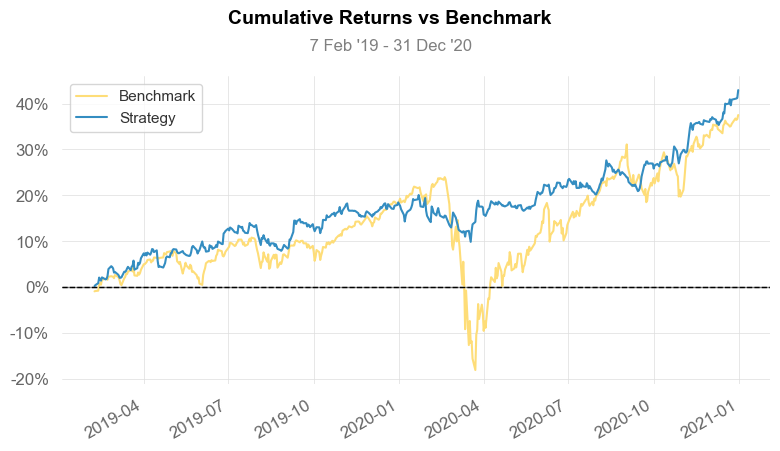

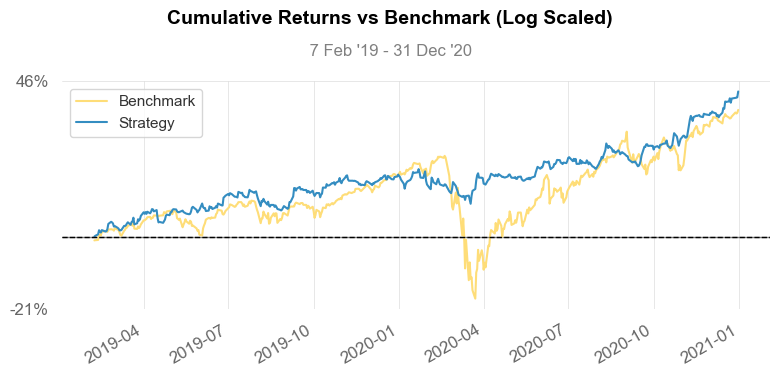

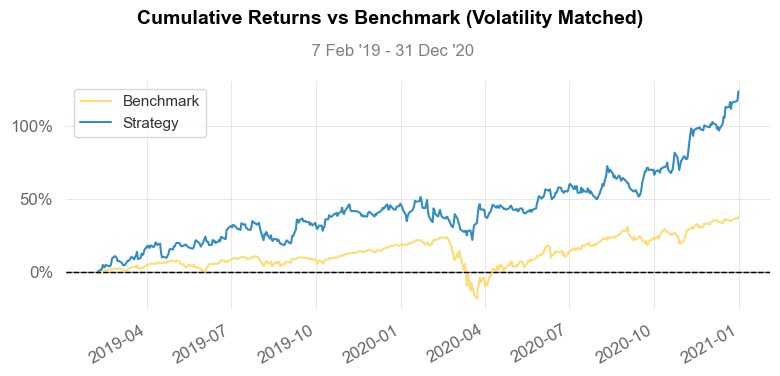

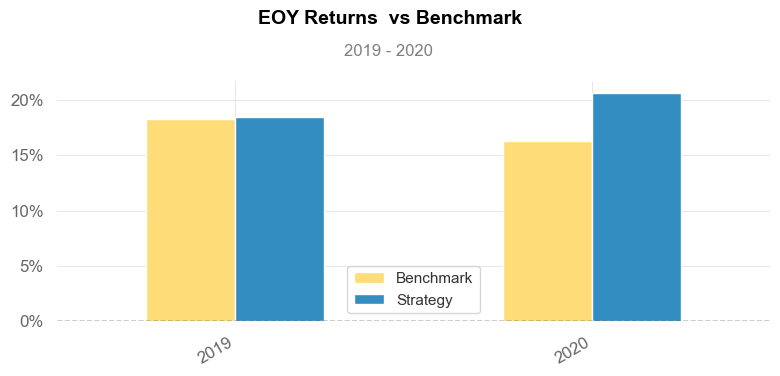

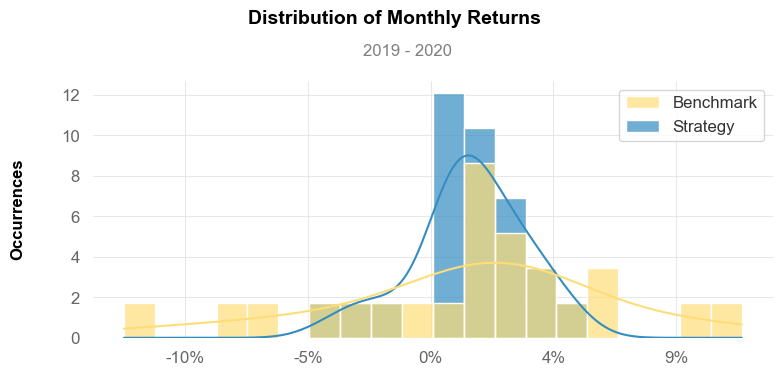

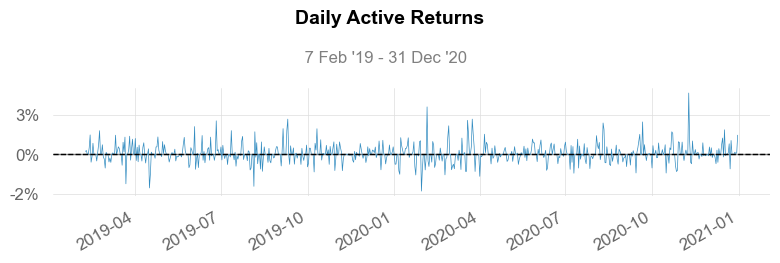

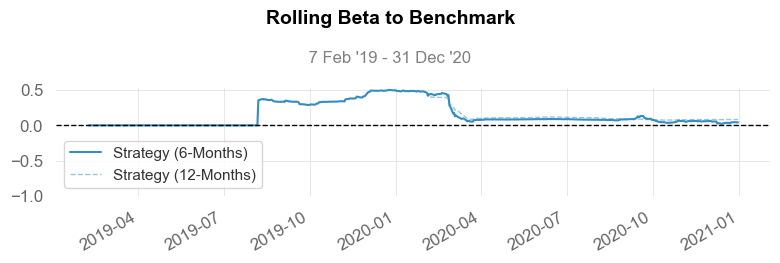

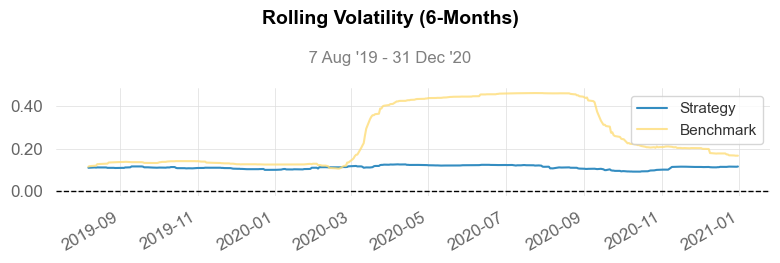

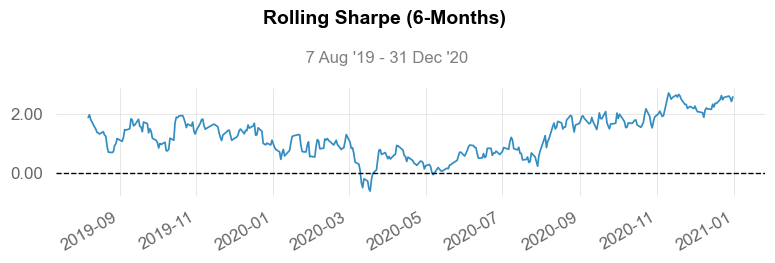

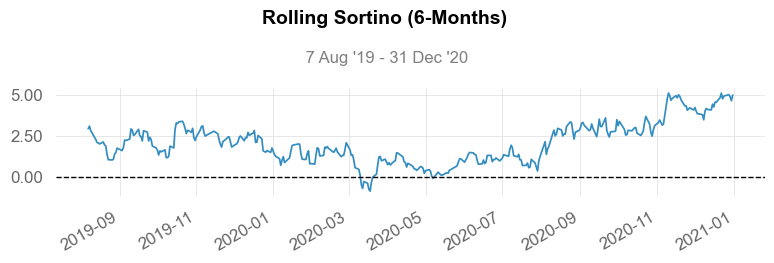

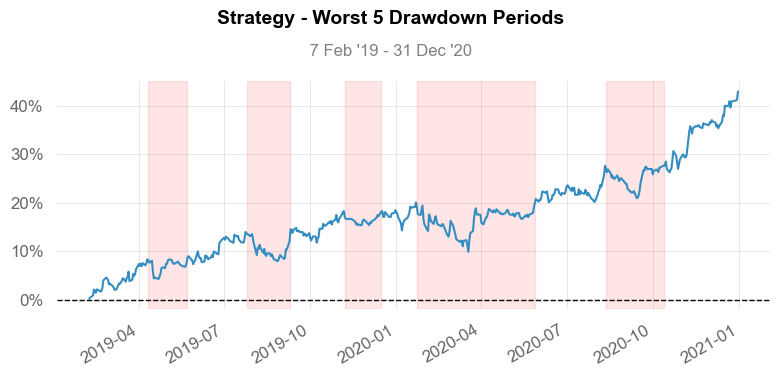

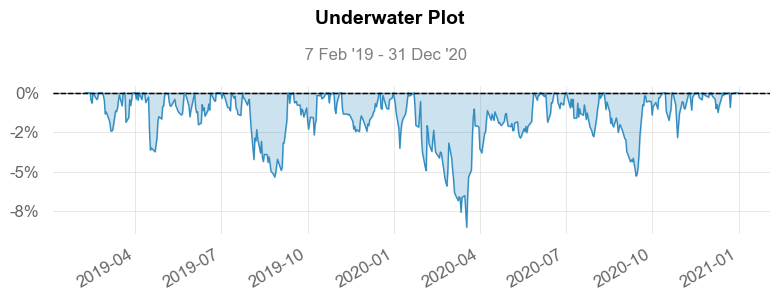

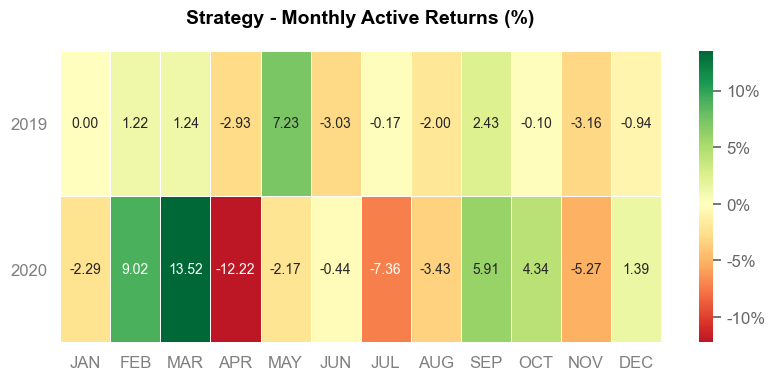

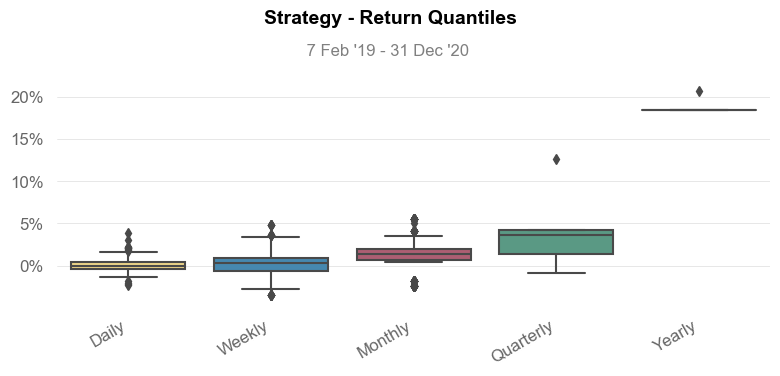

In [9]:
qs.reports.full(returns = vol_target_strategy_returns, 
                benchmark = spx_returns,
                output = 'report.html', 
                title = 'MP-filtered PCA Strategy with Volatility Targeting vs. S&P 500')